In [262]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import mlab

import seaborn as sns
#sns.set_style("whitegrid")

plt.style.use('ggplot')
%matplotlib inline

In [3]:
df_domains = pd.read_csv('data/domain.csv',sep=',', encoding='latin1', keep_default_na=False)
df_links = pd.read_csv('data/links.csv',sep='|', encoding='latin1', keep_default_na=False)

## Distribution of news websites using AMP

This is the distribution of AMP-enabled vs non AMP-enabled websites in Africa. Out of the 56 countries and territories surveyed in Africa, 40 (71.5%) have at least one of their news website running on AMP. Out of 1431 domains collected, 194 domains are AMP-enabled i.e. around 13.5%. This represents quite a significant level of popularity of the AMP platform on the continent. The countries with the highest number of AMP-enabled news websites are KE, ZM, NG and ZA. Figure below shows a distribution of AMP vs Non-AMP websites by country, where there is at least 2 AMP-enabled domains.


In [4]:
z = []
for index, row in df_domains.iterrows():
    z.append(len(df_links.loc[df_links.domain==row['domain']]))
df_domains['amp_links_count'] = z

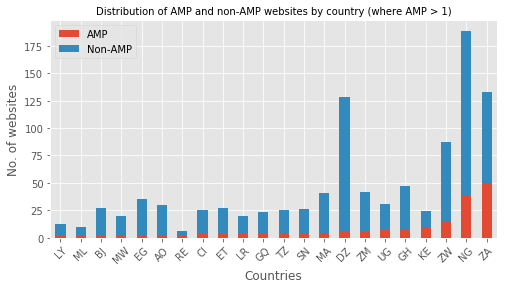

In [5]:
df1 = df_domains.iloc[:,[2,12]]
non_amp_domains = df1.loc[df1.amp_links_count == 0].groupby('cc').size()
amp_enabled_domains = df1.loc[df1.amp_links_count > 0].groupby('cc').size()

df2 = pd.DataFrame(columns=['cc','AMP','Non-AMP'])

for cc in df1['cc'].drop_duplicates():
    non_amp_size = 0
    amp_size = 0
    
    try:
        non_amp_size = non_amp_domains[cc]
        amp_size = amp_enabled_domains[cc]
    except KeyError:
        pass
    
    df2 = df2.append({'cc':cc, 'AMP': amp_size, 'Non-AMP':  non_amp_size}, ignore_index=True)
    
#df2['total'] = df2.apply(lambda row: row['AMP'] + row['Non-AMP'], axis=1)
#df2 = df2.iloc[:,[0,1,3]]

df2 = df2.loc[df2['AMP']>1].sort_values(by='AMP', ascending=True)

ax = df2.plot.bar(stacked=True, figsize=(8,4), x='cc', rot=45, fontsize=10)
plt.ylabel('No. of websites')
#plt.grid(True)
plt.title("Distribution of AMP and non-AMP websites by country (where AMP > 1)", fontsize=10)
plt.xlabel('Countries')
plt.savefig("data/plots/distribution_website_amp_vs_nonamp.pdf")
plt.show()

## AMP Artifacts and Web QoE
AMP pages can be broken down in four components:
1. **Original url**: The original news page
2. **Original AMP url**: The AMP version of the original url, hosted by the news website
3. **AMP Viewer url**: The AMP page as hosted by google, it's domain is "www.google.com/amp/..."
4. **AMP Cache url**: The AMP page as cached by google in one of it's CDN, the domain is "www-example-com.cdn.ampproject.org/...."

We are going to run measurements SpeedChecker probes from the countries in which the websites are local to. The platform has a limit on the number of API calls and the number of tests you can run in one day, we have therefore selected a sample of around 500 URLs from all 40 countries that have at least one AMP-enabled domain. However, at the time of the experiment only 30 countries have active probes. For the sake of this experiment, we took a sample of 15 news links by country.

We have run Web QoE tests and extracted the following metrics:
1. DNSLookupTime: Time to resolve the domain
2. HTTPStatus: Status of the HTTP request
3. InitialConnection: Time for the initial handshake
4. NumberOfRequests: Number of individual requests made to download the page
5. PageLoadTime: Time it takes to load a page
6. SSLNegotiationTime: Time it takes to do the SSL handshake
7. TTFB: Time to first byte
8. TotalDownloadedBytes: Size of the page

# Web QoE analysis 

In [210]:
df_ori_amp_results = pd.read_csv('data/ori_amp_url_results.csv', sep='|', encoding='utf-8', keep_default_na=False)
df_ori_amp_results = df_ori_amp_results[(df_ori_amp_results.HTTPStatus=='200') & (df_ori_amp_results.StatusText=='OK')]

df_amp_viewer_results = pd.read_csv('data/amp_viewer_url_results.csv', sep='|', encoding='utf-8', keep_default_na=False)
df_amp_viewer_results = df_amp_viewer_results[(df_amp_viewer_results.HTTPStatus==200) & (df_amp_viewer_results.StatusText=='OK')]

df_amp_cdn_results = pd.read_csv('data/amp_cdn_url_results.csv', sep='|', encoding='utf-8', keep_default_na=False)
df_amp_cdn_results = df_amp_cdn_results[(df_amp_cdn_results.HTTPStatus=='200') & 
                                        (df_amp_cdn_results.StatusText=='OK') & 
                                        (df_amp_cdn_results.InitialConnection > 0)]

df_url_results = pd.read_csv('data/url_results.csv', sep='|', encoding='utf-8', keep_default_na=False)
df_url_results = df_url_results[(df_url_results.HTTPStatus==200) & (df_url_results.StatusText=='OK')]

#bytes into KB
df_ori_amp_results['TotalDownloadedBytes'] = df_ori_amp_results.apply(lambda x: x['TotalDownloadedBytes']/1000, axis=1)
df_amp_viewer_results['TotalDownloadedBytes'] = df_amp_viewer_results.apply(lambda x: x['TotalDownloadedBytes']/1000, axis=1)
df_amp_cdn_results['TotalDownloadedBytes'] = df_amp_cdn_results.apply(lambda x: x['TotalDownloadedBytes']/1000, axis=1)
df_url_results['TotalDownloadedBytes'] = df_url_results.apply(lambda x: x['TotalDownloadedBytes']/1000, axis=1)

df_size1 = df_url_results.iloc[:,[1,6,9,11,12,13,14]]
df_size1 = df_size1.assign(Type='A. Web URL')

df_size2 = df_ori_amp_results.iloc[:,[1,6,9,11,12,13,14]]
df_size2 = df_size2.assign(Type='B. Original AMP URL')

df_size3 = df_amp_viewer_results.iloc[:,[1,6,9,11,12,13,14]]
df_size3 = df_size3.assign(Type='C. AMP Viewer URL')

df_size4 = df_amp_cdn_results.iloc[:,[1,6,9,11,12,13,14]]
df_size4 = df_size4.assign(Type='D. AMP CDN URL')

df_sizes = pd.concat([df_size1, df_size2, df_size3, df_size4])

## Seaborn boxplots
### TotalDownloadedBytes
Boxplot of URL Type vs Page size.

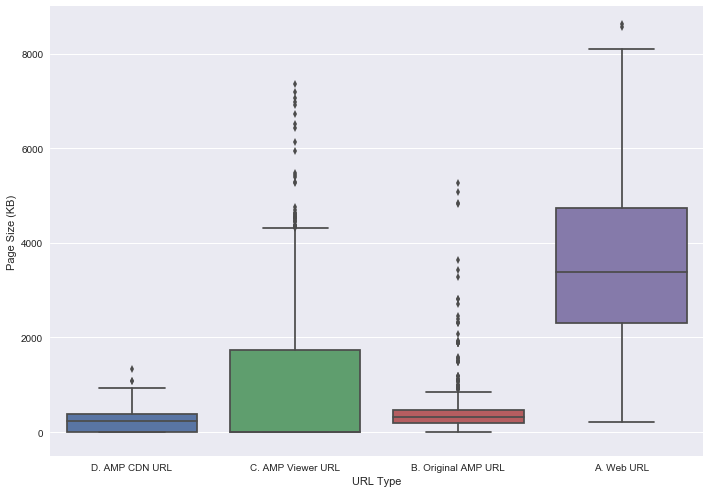

<Figure size 7200x432 with 0 Axes>

In [271]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
my_order = df_sizes.groupby(by=["Type"])["TotalDownloadedBytes"].median().iloc[::-1].index
#sns.stripplot(x="Type", y="TotalDownloadedBytes", data=df_sizes, jitter=True, palette="Set2", dodge=True,linewidth=1,edgecolor='gray')
ax = sns.boxplot(x="Type", y="TotalDownloadedBytes", data=df_sizes, order=my_order)
ax.set(xlabel='URL Type', ylabel='Page Size (KB)')
ax.set(ylim=(-500, 9000))
plt.figure(figsize=(100,6))
ax.get_figure().savefig("data/plots/boxplot_URLType_PageSize.pdf")
plt.show()

Comparison between countries and URL Type 
**Issue: Not all countries were measured for the 4 different URL Type, need to re-run measurements again and take a subset**

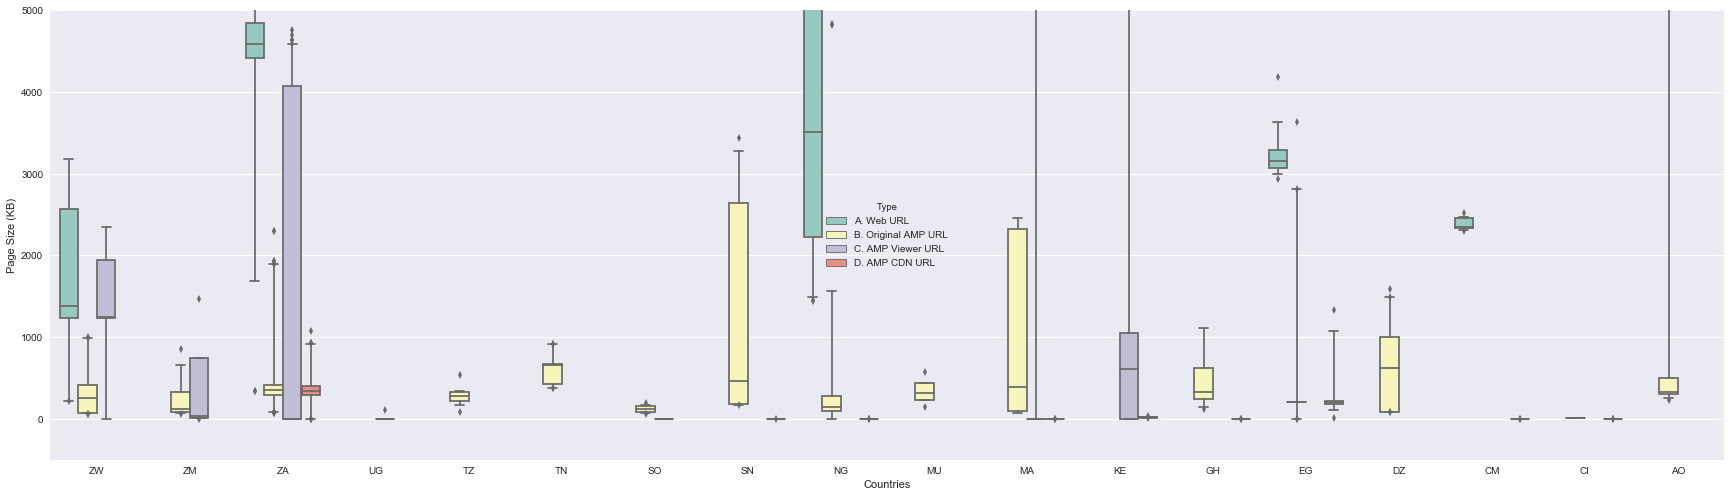

In [272]:
sns.set(rc={'figure.figsize':(30,8.27)})
my_order = df_sizes.groupby(by=["cc"])["TotalDownloadedBytes"].median().iloc[::-1].index
#sns.stripplot(x="Type", y="TotalDownloadedBytes", data=df_sizes, jitter=True, palette="Set2", dodge=True,linewidth=1,edgecolor='gray')
ax = sns.boxplot(x="cc", y="TotalDownloadedBytes", hue='Type', data=df_sizes, order=my_order, palette="Set3", whis=[5,95])
ax.set(xlabel='Countries', ylabel='Page Size (KB)')
ax.set(ylim=(-500, 5000))
#plt.figure(figsize=(100,6))
ax.get_figure().savefig("data/plots/boxplot_countries_URLType_PageSize.pdf")
plt.show()

### PageLoadTime

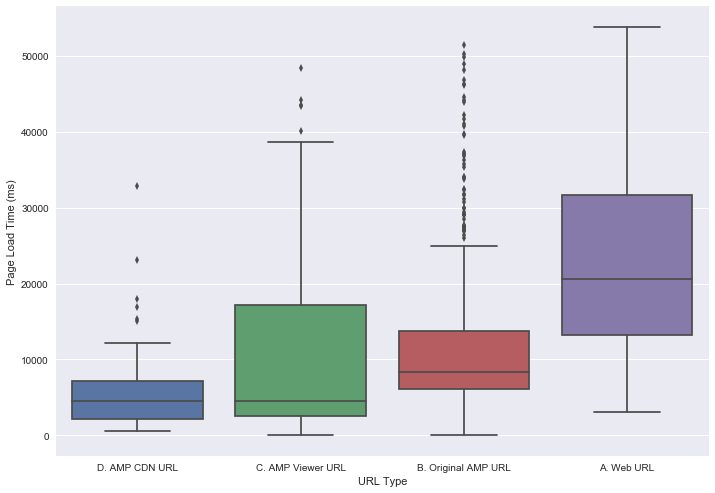

<Figure size 7200x432 with 0 Axes>

In [273]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
my_order = df_sizes.groupby(by=["Type"])["PageLoadTime"].median().iloc[::-1].index
#sns.stripplot(x="Type", y="PageLoadTime", data=df_sizes, jitter=True, palette="Set2", dodge=True,linewidth=1,edgecolor='gray')
ax = sns.boxplot(x="Type", y="PageLoadTime", data=df_sizes, order=my_order)
ax.set(xlabel='URL Type', ylabel='Page Load Time (ms)')
#ax.set(ylim=(-500, 9000))
plt.figure(figsize=(100,6))
ax.get_figure().savefig("data/plots/boxplot_URLType_PageLoadTime.pdf")
plt.show()

### TTFB

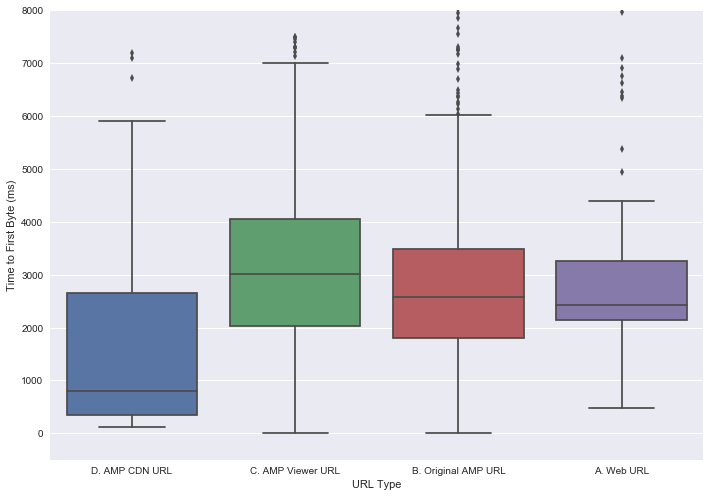

In [287]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
my_order = df_sizes.groupby(by=["Type"])["TTFB"].median().iloc[::-1].index
#sns.stripplot(x="Type", y="TTFB", data=df_sizes, jitter=True, palette="Set2", dodge=True,linewidth=1,edgecolor='gray')
ax = sns.boxplot(x="Type", y="TTFB", data=df_sizes, order=my_order)
ax.set(xlabel='URL Type', ylabel='Time to First Byte (ms)')
ax.set(ylim=(-500, 8000))
#plt.figure(figsize=(100,6))
ax.get_figure().savefig("data/plots/boxplot_URLType_TTFB.pdf")
plt.show()

### SSLNegotiationTime

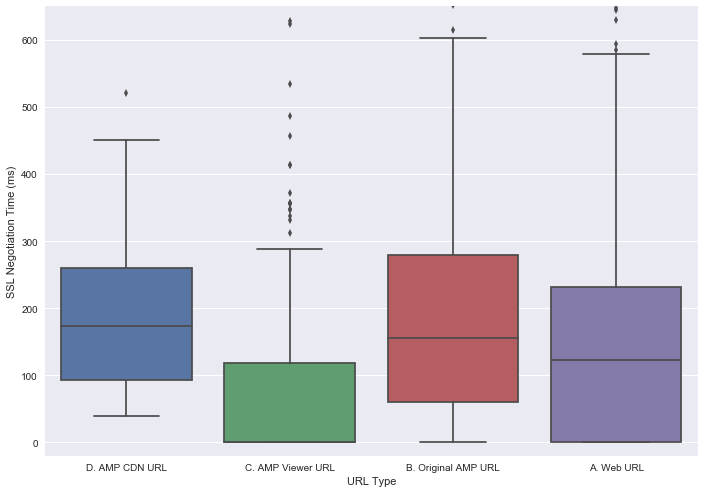

In [286]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
my_order = df_sizes.groupby(by=["Type"])["SSLNegotiationTime"].median().iloc[::-1].index
#sns.stripplot(x="Type", y="TTFB", data=df_sizes, jitter=True, palette="Set2", dodge=True,linewidth=1,edgecolor='gray')
ax = sns.boxplot(x="Type", y="SSLNegotiationTime", data=df_sizes, order=my_order)
ax.set(xlabel='URL Type', ylabel='SSL Negotiation Time (ms)')
ax.set(ylim=(-20, 650))
#plt.figure(figsize=(100,6))
ax.get_figure().savefig("data/plots/boxplot_URLType_SSL.pdf")
plt.show()

### DNSLookupTime

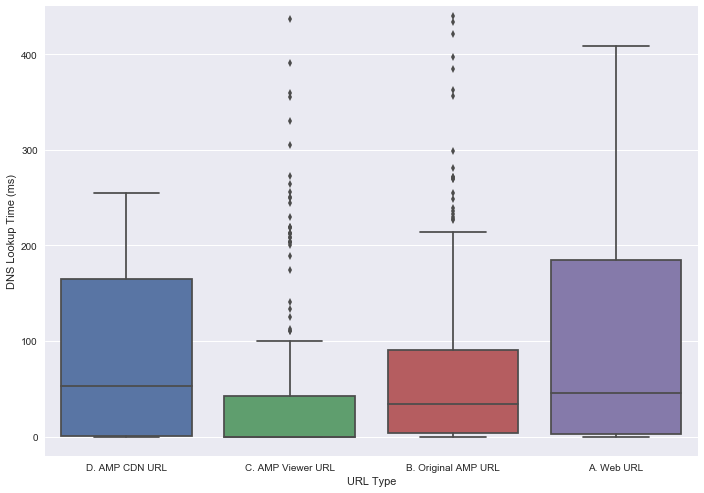

In [289]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
my_order = df_sizes.groupby(by=["Type"])["DNSLookupTime"].median().iloc[::-1].index
#sns.stripplot(x="Type", y="TTFB", data=df_sizes, jitter=True, palette="Set2", dodge=True,linewidth=1,edgecolor='gray')
ax = sns.boxplot(x="Type", y="DNSLookupTime", data=df_sizes, order=my_order)
ax.set(xlabel='URL Type', ylabel='DNS Lookup Time (ms)')
ax.set(ylim=(-20, 450))
#plt.figure(figsize=(100,6))
ax.get_figure().savefig("data/plots/boxplot_URLType_DNS.pdf")
plt.show()

## Matplotlib Boxplots

### Total Download Bytes (KB)

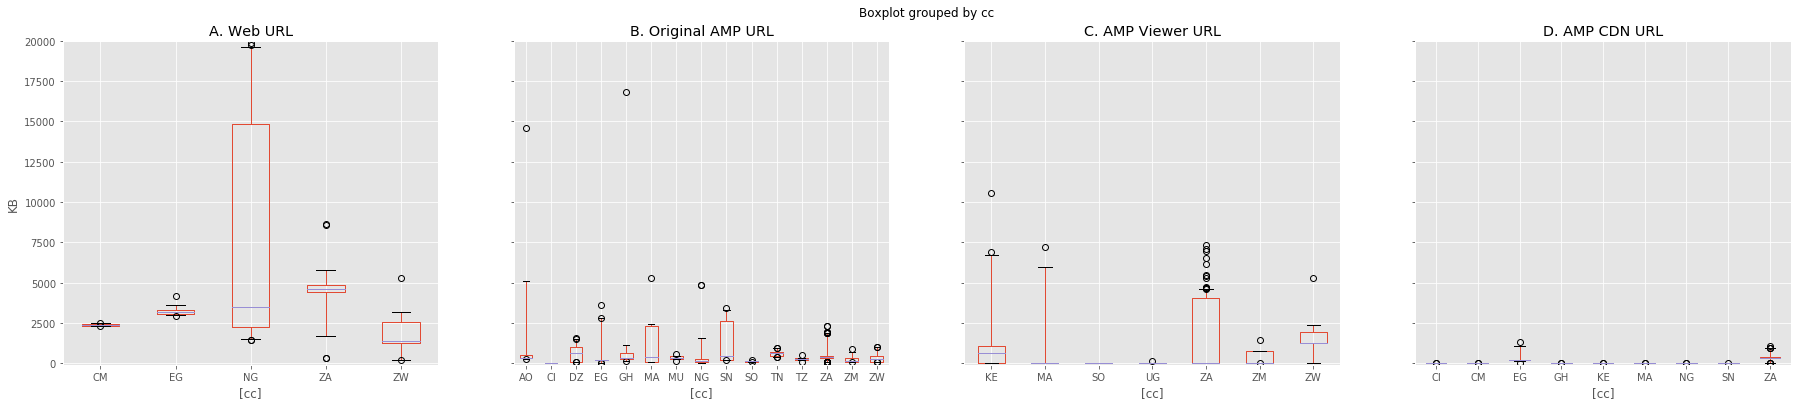

In [179]:
axes = df_sizes.groupby('Type').boxplot(column='TotalDownloadedBytes', by=['cc'], figsize=(30,6), layout=(1,4), whis=[5,95])

for ax in axes.values:
    ax.set_ylim(-100, 20000)
    ax.set_ylabel("KB", fontsize=12)

plt.savefig("data/plots/boxplot_TotalDownloadedBytes.pdf")
plt.show()

### Page Load Time

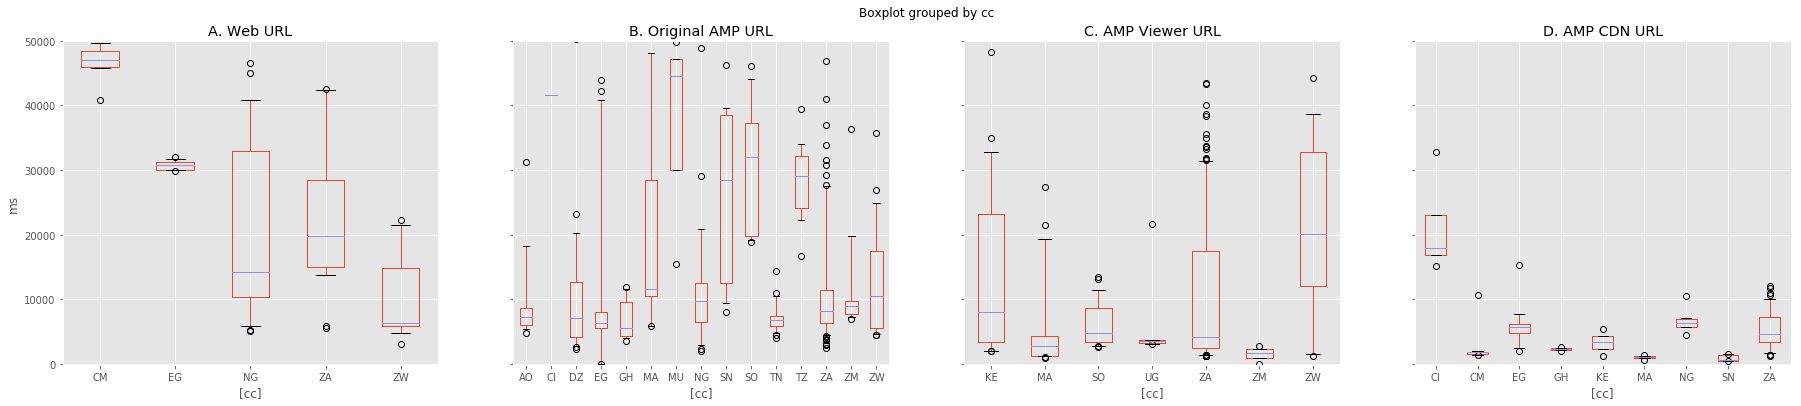

In [168]:
axes = df_sizes.groupby('Type').boxplot(column='PageLoadTime', by=['cc'], figsize=(30,6), layout=(1,4), whis=[5,95])

for ax in axes.values:
    ax.set_ylim(-100, 50000)
    ax.set_ylabel("ms", fontsize=12)

plt.savefig("data/plots/boxplot_PageLoadTime.pdf")
plt.show()

### TTFB

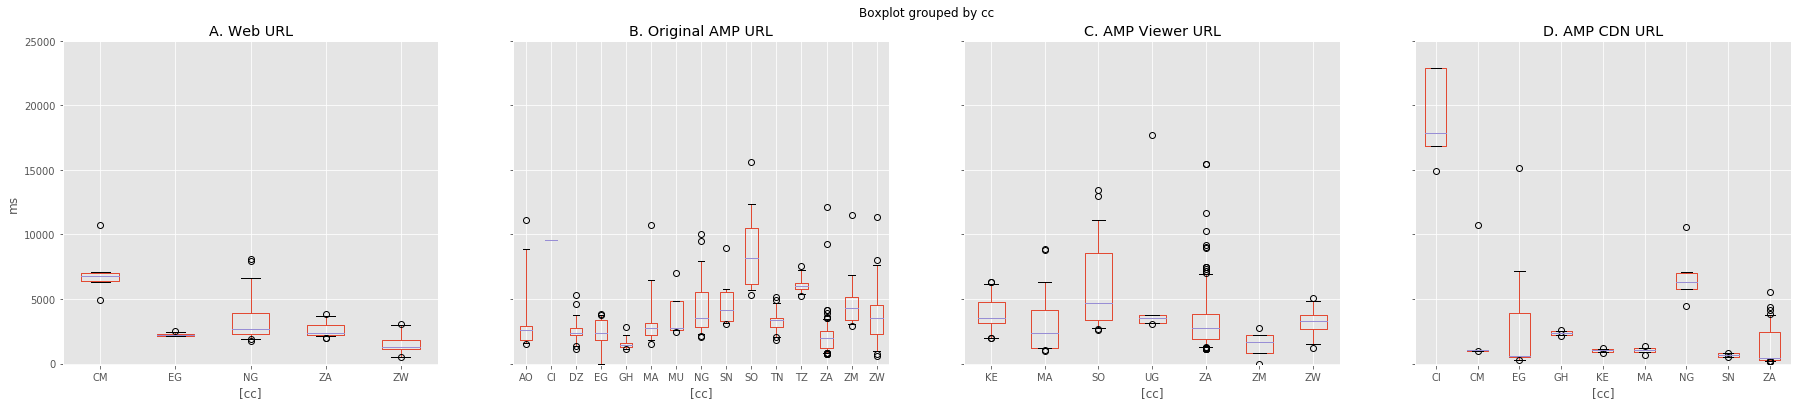

In [164]:
axes = df_sizes.groupby('Type').boxplot(column='TTFB', by=['cc'], figsize=(30,6), layout=(1,4), whis=[5,95])

for ax in axes.values:
    ax.set_ylim(-100, 25000)
    ax.set_ylabel("ms", fontsize=12)

plt.savefig("data/plots/boxplot_TTFB.pdf")
plt.show()

### SSLNegotiationTime

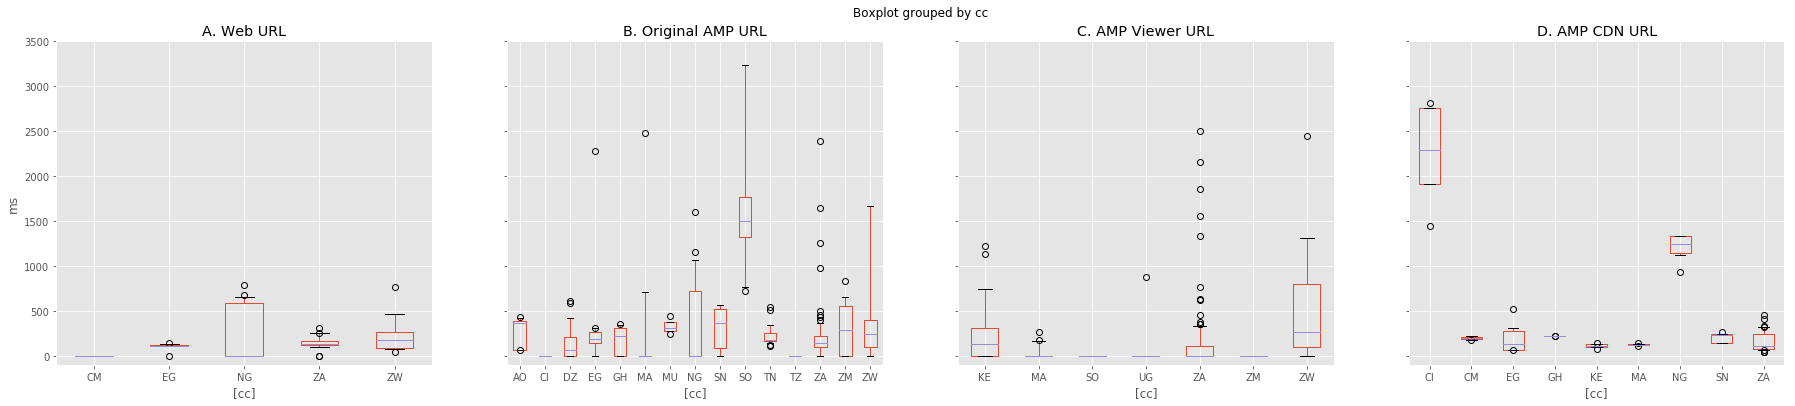

In [163]:
axes = df_sizes.groupby('Type').boxplot(column='SSLNegotiationTime', by=['cc'], figsize=(30,6), layout=(1,4), whis=[5,95])

for ax in axes.values:
    ax.set_ylim(-100, 3500)
    ax.set_ylabel("ms", fontsize=12)

plt.savefig("data/plots/boxplot_SSLNegotiationTime.pdf")
plt.show()

### DNSLookupTime

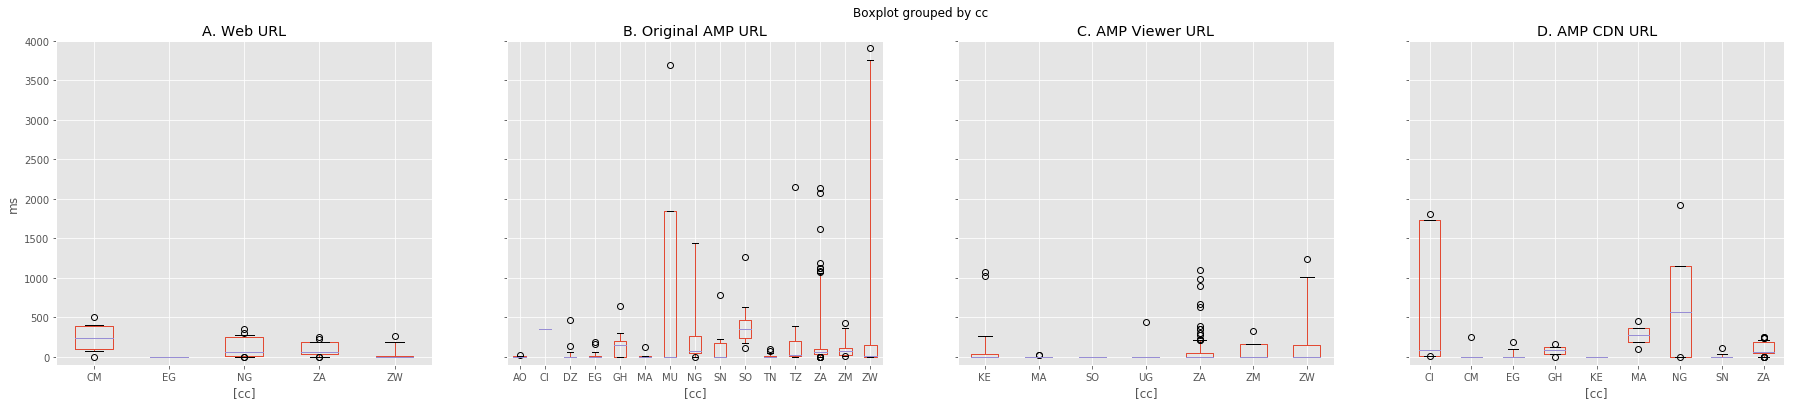

In [167]:
axes = df_sizes.groupby('Type').boxplot(column='DNSLookupTime', by=['cc'], figsize=(30,6), layout=(1,4), whis=[5,95])

for ax in axes.values:
    ax.set_ylim(-100, 4000)
    ax.set_ylabel("ms", fontsize=12)

plt.savefig("data/plots/boxplot_DNSLookupTime.pdf")
plt.show()

### InitialConnection

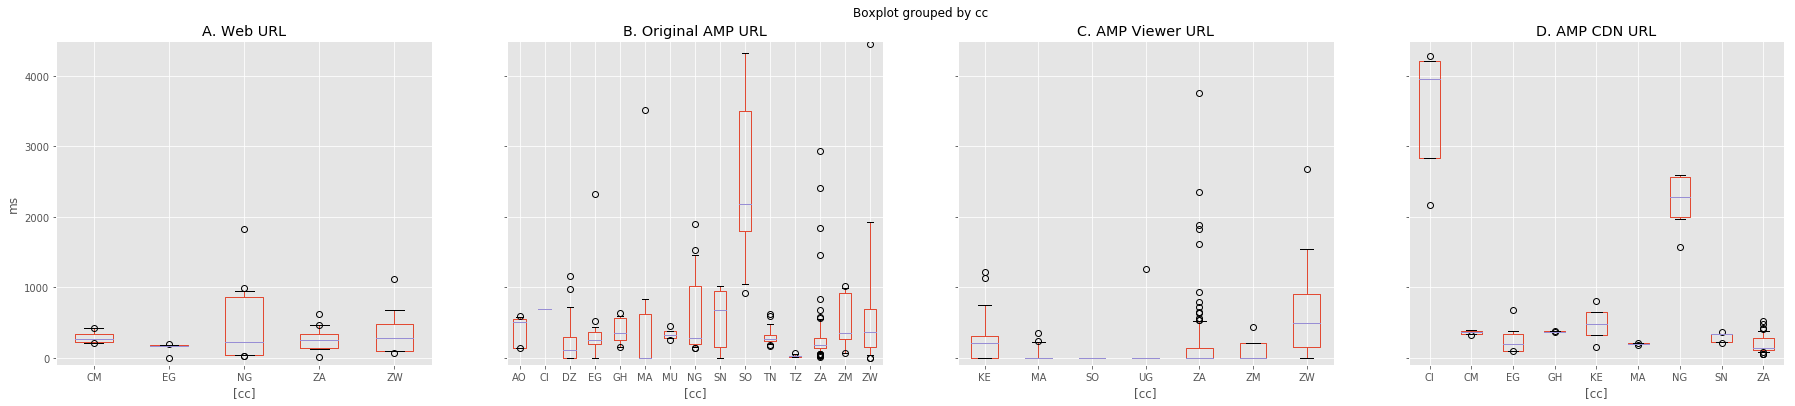

In [171]:
axes = df_sizes.groupby('Type').boxplot(column='InitialConnection', by=['cc'], figsize=(30,6), layout=(1,4), whis=[5,95])

for ax in axes.values:
    ax.set_ylim(-100, 4500)
    ax.set_ylabel("ms", fontsize=12)

plt.savefig("data/plots/boxplot_InitialConnection.pdf")
plt.show()

## Individual plots (Original AMP)

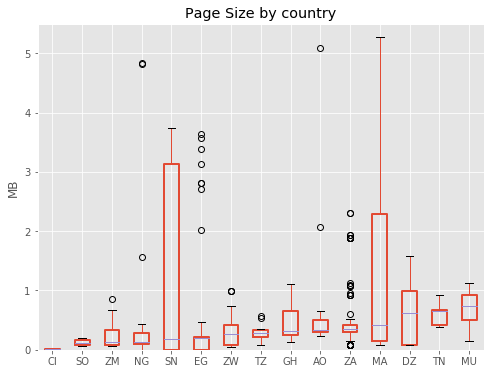

In [45]:
axes = boxplot_sorted(df_ori_amp_results, by=["cc"], column="TotalDownloadedBytes")
axes.figure.set_size_inches(8,6)
axes.set_title("Page Size by country")
axes.set_ylim([0,5.5])
axes.set_ylabel("MB", fontsize=12)

plt.savefig("data/plots/ori_amp_url/boxplot_TotalDownloadedBytes.pdf")
plt.show()

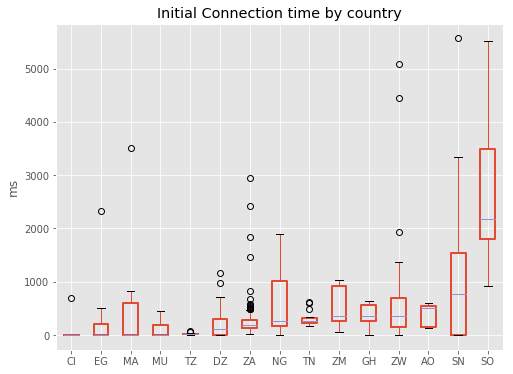

In [17]:
axes = boxplot_sorted(df_ori_amp_results, by=["cc"], column="InitialConnection")
axes.figure.set_size_inches(8,6)
axes.set_title("Initial Connection time by country")
#axes.set_ylim([0,120])
axes.set_ylabel("ms", fontsize=12)

plt.savefig("data/plots/ori_amp_url/boxplot_initial_connection.pdf")
plt.show()

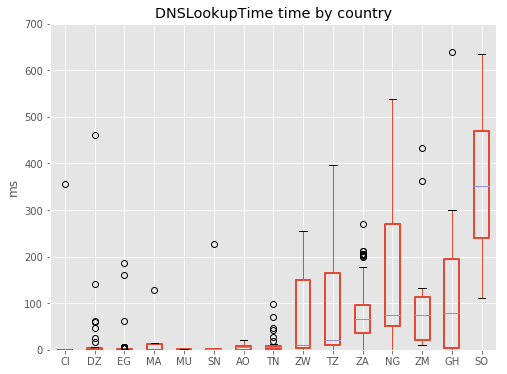

In [21]:
axes = boxplot_sorted(df_ori_amp_results, by=["cc"], column="DNSLookupTime")
axes.figure.set_size_inches(8,6)
axes.set_title("DNSLookupTime by country")
axes.set_ylim([0,700])
axes.set_ylabel("ms", fontsize=12)

plt.savefig("data/plots/ori_amp_url/boxplot_DNSLookupTime.pdf")
plt.show()

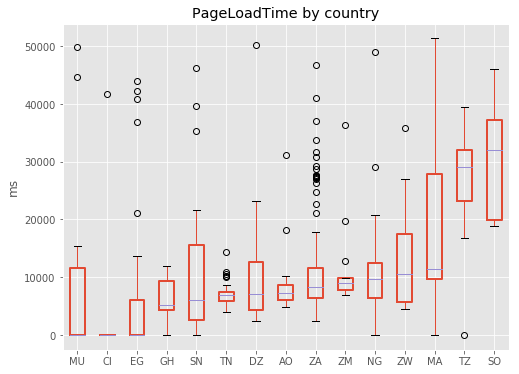

In [23]:
axes = boxplot_sorted(df_ori_amp_results, by=["cc"], column="PageLoadTime")
axes.figure.set_size_inches(8,6)
axes.set_title("PageLoadTime by country")
#axes.set_ylim([0,700])
axes.set_ylabel("ms", fontsize=12)

plt.savefig("data/plots/ori_amp_url/boxplot_PageLoadTime.pdf")
plt.show()

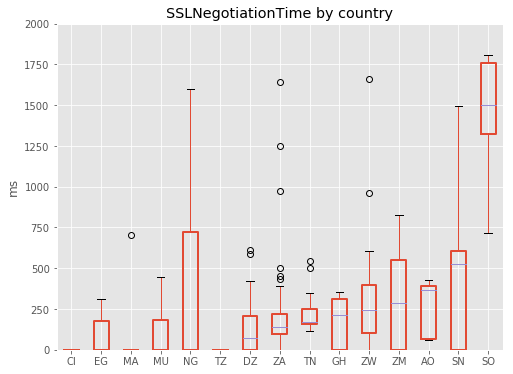

In [25]:
axes = boxplot_sorted(df_ori_amp_results, by=["cc"], column="SSLNegotiationTime")
axes.figure.set_size_inches(8,6)
axes.set_title("SSLNegotiationTime by country")
axes.set_ylim([0,2000])
axes.set_ylabel("ms", fontsize=12)

plt.savefig("data/plots/ori_amp_url/boxplot_SSLNegotiationTime.pdf")
plt.show()

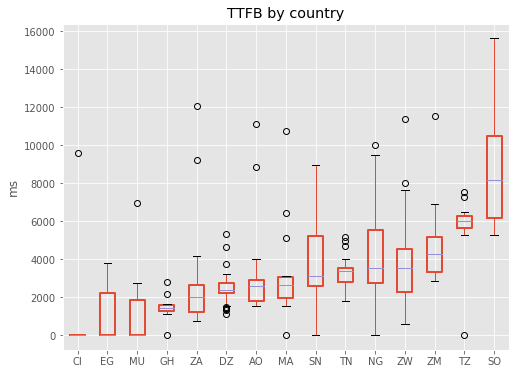

In [39]:
axes = boxplot_sorted(df_ori_amp_results, by=["cc"], column="TTFB")
axes.figure.set_size_inches(8,6)
axes.set_title("TTFB by country")
#axes.set_ylim([0,2000])
axes.set_ylabel("ms", fontsize=12)

plt.savefig("data/plots/ori_amp_url/boxplot_TTFB.pdf")
plt.show()